In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import math
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl

In [2]:
df = pd.read_csv("AAPL.CSV")
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
247,2019-09-05,212.000000,213.970001,211.509995,213.279999,213.279999,23913700
248,2019-09-06,214.050003,214.419998,212.509995,213.259995,213.259995,19362300
249,2019-09-09,214.839996,216.440002,211.070007,214.169998,214.169998,27309400
250,2019-09-10,213.860001,216.779999,211.710007,216.699997,216.699997,31693800
251,2019-09-11,218.070007,223.639999,217.729996,223.589996,223.589996,41217957


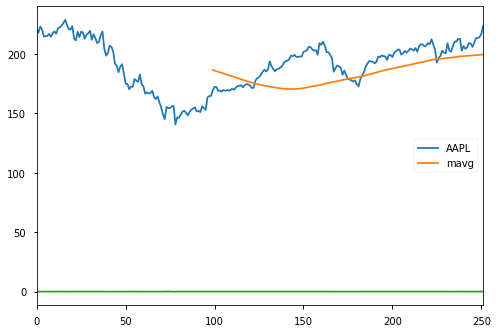

In [3]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()


%matplotlib inline
# Adjusting the size of matplotlib

mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('seaborn-notebook')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')



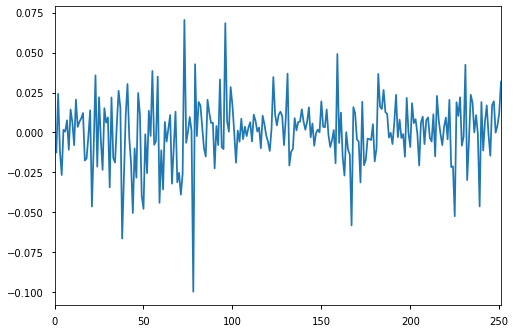

In [4]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [5]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [6]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.02 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately  = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [7]:
forecast_out

6

In [8]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Lasso())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lasso',
                 Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=1000, normalize=False, positive=False,
                       precompute=False, random_state=None, selection='cyclic',
                       tol=0.0001, warm_start=False))],
         verbose=False)

In [11]:
confidencereg = clfreg.score(X_test, y_test)
confidencereg #0.8248525838820094
confidencereg = clfpoly2.score(X_test, y_test)
confidencereg #0.8302955914080861
confidencereg = clfpoly3.score(X_test, y_test)
confidencereg #0.8050446460438349

0.8050446460438349

In [12]:
forecast_set = clfpoly2.predict(X_lately)
dfreg['Forecast'] = np.nan
#result
forecast_set

array([208.74814006, 209.39093209, 213.51186965, 215.60202453,
       211.30428243, 211.01587988])

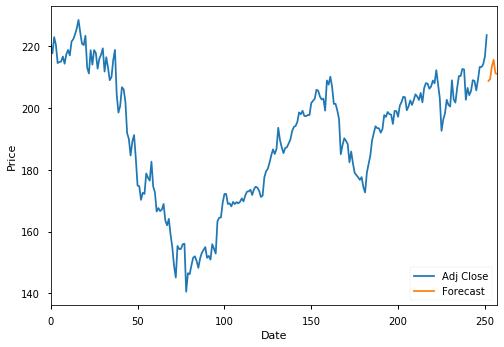

In [13]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + 1

for i in forecast_set:
    next_date = next_unix
    next_unix += 1
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()